## Streamlining workflows with pipelines

In [1]:
import pandas as pd

# Load the Breast Cancer Wisconsin dataset from UCI ML repository
# This dataset has no header row, so we set header=None
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
    header=None
)

# Preview first few rows
print(df.head())

         0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.

In [2]:
# Next assign the 30 features to NumPy array and using LabelEncoder, we convert labels from string representation to integers.
from sklearn.preprocessing import LabelEncoder

# Separate features (columns 2 onward) and labels (column 1)
X = df.loc[:, 2:].values   # features (30 real-valued measurements)
y = df.loc[:, 1].values    # target labels (M or B)

# Encode string labels into integers
le = LabelEncoder()
y = le.fit_transform(y)

# Show the mapping between original labels and encoded values
print(le.classes_)

['B' 'M']


In [3]:
# Double check the mapping taht malignant (M) is 1 and benign (B) is 0
le.transform(['M', 'B'])

array([1, 0])

In [4]:
# Before constructing first model pipeline, divide the dataset into training and test sets.
from sklearn.model_selection import train_test_split

# Split data into training and test sets
# - test_size=0.20 → 20% of the data goes into the test set
# - stratify=y → preserves the same proportion of benign/malignant cases in train & test
# - random_state=1 → ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=1
)

In [5]:
# Do standardization, PCA, and Logistic Regression in a single pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Create a pipeline with 3 steps:
# 1. Standardize the features (StandardScaler)
# 2. Reduce dimensionality to 2 components (PCA)
# 3. Train a Logistic Regression classifier
pipe_lr = make_pipeline( # make_pipeline takes an arbitrary number of steps
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression() # if we want to use pipeline for prediction tasks, last pipeline element must be an estimator
)

# Fit the model pipeline on the training data
pipe_lr.fit(X_train, y_train) # during this, all intermediate steps are executed in sequence, with .fit() then .transform() called on each step except the last one, where .fit() is called directly on the estimator

# Predict the labels for the test set
y_pred = pipe_lr.predict(X_test) # during this, all intermediary steps call .transform() method, and the final step calls .predict() method

# Evaluate the accuracy of the model on the test set
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


## Cross-validation: Stratified K-Folds

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Create a stratified k-fold cross-validator with 10 folds
# Stratification ensures that the class distribution in each fold
# matches the overall class distribution in the dataset.
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []

# Loop through each fold (train/test split)
for k, (train, test) in enumerate(kfold):
    # Fit the pipeline (scaler + PCA + logistic regression)
    # using the training indices of this fold
    pipe_lr.fit(X_train[train], y_train[train])
    
    # Evaluate accuracy on the validation/test indices of this fold
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    
    # Print fold number, class distribution in training set,
    # and accuracy of this fold
    print(
        f'Fold: {k+1:02d}, '
        f'Class distr.: {np.bincount(y_train[train])}, '
        f'Acc.: {score:.3f}'
    )

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956


In [7]:
# Using scikit-learn's k-fold cross-validator scorer, allowing less verbose output
from sklearn.model_selection import cross_val_score

# Perform 10-fold cross-validation on the training data
# estimator = our pipeline (scaler + PCA + logistic regression)
# cv=10 means 10 folds
# n_jobs=1 means run on a single CPU core (could set -1 to use all cores)
scores = cross_val_score(estimator=pipe_lr, 
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)# very useful feature of cross_val_score is that the folds can be evaluated across multiple CPUs on machine, as determined by n_jobs parameter; setting n_jobs=-1 will use all available CPU cores, speeding up the process significantly

# Print the accuracy score for each fold
print(f'CV accuracy scores: {scores}')

# Print the mean accuracy and the standard deviation
# Mean = overall performance
# Std = how much the performance varied across folds
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## Debugging algos with learning and validation curves

### Learning Curves to diagnose bias and variance

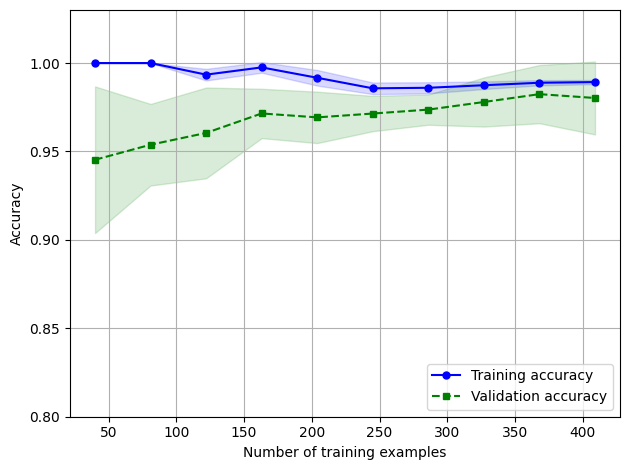

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Build a pipeline:
# 1) StandardScaler standardizes features (zero mean, unit variance)
# 2) LogisticRegression is the classifier
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', max_iter=10000)
)

# Compute learning curve data:
# - train_sizes: fractions of training set used (10% to 100%)
# - train_scores: cross-validated training accuracy
# - test_scores: cross-validated validation accuracy
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,          # training features
    y=y_train,          # training labels
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points between 10% and 100%
    cv=10,              # 10-fold cross-validation
    n_jobs=1            # run in single process
)

# Compute mean & std across folds for plotting with error bands
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot training accuracy curve
plt.plot(train_sizes, train_mean,
         color='blue', marker='o', markersize=5,
         label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')  # shaded error band

# Plot validation accuracy curve
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--', marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')  # shaded error band

# Final plot formatting
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])  # lock y-axis range for clarity
plt.tight_layout()
plt.show() # generally as training examples increase, training accuracy increases and validation accuracy stabilizes; if training accuracy is high but validation accuracy is low, it indicates overfitting; if both are low, it indicates underfitting
# after 250 examples it seems to be pretty good, but less than that it is seemingly overfitting

### Validation curves to address overfitting and underfitting

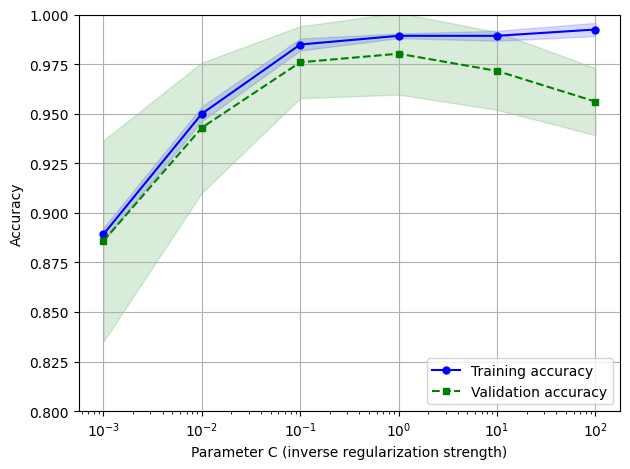

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Define the range of values for hyperparameter C (inverse of regularization strength)
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Compute training and validation scores for different C values
# - validation_curve runs cross-validation internally
# - param_name matches the LogisticRegression "C" inside the pipeline
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,                 # pipeline (scaler + logistic regression)
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',  # name of parameter inside pipeline
    param_range=param_range,
    cv=10                              # 10-fold CV
)

# Calculate mean and std across folds for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot training accuracy curve
plt.plot(param_range, train_mean,
         color='blue', marker='o', markersize=5,
         label='Training accuracy')
plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

# Plot validation accuracy curve
plt.plot(param_range, test_mean,
         color='green', linestyle='--', marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# Final formatting
plt.grid()
plt.xscale('log')  # log scale because C values vary by orders of magnitude
plt.legend(loc='lower right')
plt.xlabel('Parameter C (inverse regularization strength)')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show() # can see that there is a sweet sport somewhere between 0.1 and 1.0, where validation accuracy is highest; if C is too small, it leads to underfitting (high bias), if too large, it leads to overfitting (high variance); the best value of C is around 0.1-1.0, where validation accuracy is maximized

### Fine-tuning ML with grid search

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define an SVM pipeline:
# 1) Standardizes features (important for SVM performance)
# 2) Applies an SVM classifier
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# Range of parameters to search over
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

# Grid of hyperparameters to try:
# - linear kernel: only vary C
# - RBF kernel: vary both C and gamma
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]

# Perform 10-fold cross-validation for each parameter combination
# scoring='accuracy' means we rank models by accuracy
# refit=True retrains the best model on the full training set
# n_jobs=-1 uses all CPU cores
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10, # defines k in k-fold cross-validation
                  refit=True,
                  n_jobs=-1) # can change to None for single core, or -1 for all cores

# Fit the grid search object on the training data
gs = gs.fit(X_train, y_train)

# Print the mean CV accuracy of the best model
print(gs.best_score_)

# Print the hyperparameters of the best model
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [11]:
# Test the best model hyperparameters on the test set
clf = gs.best_estimator_           # extract the best model (RBF SVM with optimal C & gamma)
clf.fit(X_train, y_train)          # refit it on the full training set # not necessary if refit=True in GridSearchCV
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')  # evaluate on unseen test set

Test accuracy: 0.974


### Randomized search for hyperparameter optimization

In [12]:
import scipy.stats  # useful for probability distributions (e.g. uniform, loguniform)
                    # often used with RandomizedSearchCV to sample hyperparameters

# Define a range of values for hyperparameters (like C or gamma in SVMs)
# These values span very small (0.0001) to very large (1000.0)
# The idea is to search across a wide scale to find the best performing setting
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

In [13]:
# loguniform distribution is useful for hyperparameters that can vary by orders of magnitude
param_range = scipy.stats.loguniform(0.0001, 1000.0)

In [14]:
import numpy as np
from scipy.stats import loguniform

# Seed for reproducibility
np.random.seed(1)

# Sample 10 random values from this distribution
samples = param_range.rvs(10)
print(samples)

[8.30145146e-02 1.10222804e+01 1.00184520e-04 1.30715777e-02
 1.06485687e-03 4.42965766e-04 2.01289666e-03 2.62376594e-02
 5.98924832e-02 5.91176467e-01]


In [ ]:
# Usage very similar to GridSearchCV, but instead of exhaustively searching all combinations,can use a distrbutions for specifying parameter ranges and numbe of iterations
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import scipy.stats

# Define distributions for hyperparameters instead of fixed lists.
# Here we use loguniform to sample values across several orders of magnitude.
param_range = scipy.stats.loguniform(1e-4, 1e3)

# Create a pipeline: first scale features, then train SVM
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

# Define parameter distributions to explore
# - For linear kernel: only 'C' is relevant
# - For rbf kernel: both 'C' and 'gamma' matter
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]

# RandomizedSearchCV:
# - Samples a fixed number of random combinations (n_iter=20 here)
# - Much faster than GridSearchCV on large spaces
rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,      # automatically refits the best model
                        n_iter=20,       # try 20 random parameter settings
                        cv=10,           # 10-fold cross-validation
                        random_state=1,  # reproducibility
                        n_jobs=-1)       # run in parallel

# Fit randomized search on training data
rs = rs.fit(X_train, y_train)

# Report the best mean cross-validation accuracy found
print(rs.best_score_)

# Report the best hyperparameters found
print(rs.best_params_)


0.9780676328502416
{'svc__C': np.float64(0.05971247755848463), 'svc__kernel': 'linear'}


#### More resource-efficient hyperparamter search with successive halving

In [16]:
# Taking randomized search a step further, we can use successive halving to efficiently narrow down the best hyperparameters
from sklearn.experimental import enable_halving_search_cv

In [17]:
from sklearn.model_selection import HalvingRandomSearchCV

hs = HalvingRandomSearchCV(
    estimator=pipe_svc,               # our pipeline: scaling + SVC
    param_distributions=param_grid,   # random distributions for hyperparameters
    n_candidates='exhaust',           # try all candidates initially
    resource='n_samples',             # gradually increase training set size
    factor=1.5,                       # how much to increase resources each iteration
    random_state=1,                   # reproducibility
    n_jobs=-1                         # parallel processing
)

In [ ]:
# Then carry out the search like usual

# Fit the halving randomized search
hs = hs.fit(X_train, y_train)

# Print best results
print("Best CV score:", hs.best_score_)
print("Best hyperparameters:", hs.best_params_)

# Evaluate on test set
print(f"Test accuracy: {hs.score(X_test, y_test):.3f}") # Yields slightly better results on test set than RandomizedSearchCV, as it narrows down the search space more efficiently

Best CV score: 0.9617647058823529
Best hyperparameters: {'svc__C': np.float64(4.934834261073333), 'svc__kernel': 'linear'}
Test accuracy: 0.982


### Algo selection with nested cross-validation

In [19]:
# Can perform nested cross-validation with code as follows
# Define parameter grid:
# 1) Linear kernel: vary only C
# 2) RBF kernel: vary C and gamma
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]

# GridSearchCV: searches over param_grid using cross-validation
# cv=2 here means inner CV folds for tuning during grid search
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

# cross_val_score runs outer cross-validation to evaluate generalization
# Note: we pass `gs` (the grid search object) as the estimator
# so hyperparameter tuning is done inside each CV split.
scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)

# Report mean accuracy and standard deviation across outer folds
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.974 +/- 0.015


In [ ]:
# Using it to compare SVM model to simple decision tree classifier where we only tune its depth parameter
from sklearn.tree import DecisionTreeClassifier
# Set up GridSearchCV to tune the max_depth parameter of DecisionTreeClassifier
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),  # Decision tree model
    param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],  # values to try for max_depth
    scoring='accuracy',  # metric to optimize
    cv=2  # inner cross-validation folds for hyperparameter tuning
)

# Use cross_val_score to do outer cross-validation with 5 folds
# This runs the grid search inside each fold (nested CV)
scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)

# Print the mean accuracy and standard deviation across the 5 folds
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}') # as we can see, SVM is notably better than decision tree and so is probably better choice

CV accuracy: 0.934 +/- 0.016


## Looking at different peroformance evaluation metrics